In [24]:
%matplotlib inline

from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
from pt_tex_synth import *
import os, time

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# desired size of the output image
imsize = 256 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# Plotting and saving functions.
unloader = transforms.ToPILImage()  # reconvert into PIL image

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    #plt.pause(0.001) # pause a bit so that plots are updated

def imsave(tensor, savepath=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    image.save(savepath)  

# Load the VGG19 weights and model architecture.
cnn = models.vgg19(pretrained=True).features.to(device).eval()
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

## Edit the cell below to specify which original image and which layer

In [32]:
## Set the variables
orig_img = "fronds.jpg"
num_steps = 1000
layer = 'pool1' # Choose either pool1, pool2, pool3 or pool4.
stim_dir = '/home/users/akshayj/TextureSynthesis/stimuli/textures/orig_color'
out_dir = 'output' # Directory to save the image in.
saveName = '{}_{}.png'.format(layer, orig_img.split('.')[0]) # Save as: e.g. pool2_cherries.png

# Specify the texture image to match
texture_img = image_loader(stim_dir + '/' + orig_img)

# Randomly initialize white noise input image
init_img = torch.randn(style_img.data.size(), device=device)

# Make the output directory, if it doesn't already exist.
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

# Select layer
all_layers = ['conv1_1', 'pool1', 'pool2', 'pool3', 'pool4'];
this_layers = all_layers[:all_layers.index(layer)+1]

# Run!
t = time.time()
output_img = run_texture_synthesis(cnn, cnn_normalization_mean, cnn_normalization_std, texture_img, 
                                        init_img, num_steps=num_steps, style_layers=this_layers, 
                                        saveLoc=[stim_dir + '/' + out_dir, saveName])
elapsed = time.time() - t
print('Done synthesizing! Took {} seconds'.format(elapsed))

Building the style transfer model..
Optimizing..
Step #50 style loss: 262.230042
Step #100 style loss: 5.291419
Step #150 style loss: 1.141380
Step #200 style loss: 16.157406
Step #250 style loss: 0.281272
Step #300 style loss: 0.095018
Step #350 style loss: 0.038579
Step #400 style loss: 0.015690
Step #450 style loss: 0.010624
Step #500 style loss: 0.015881
Step #550 style loss: 0.005448
Step #600 style loss: 0.004097
Step #650 style loss: 0.003150
Step #700 style loss: 0.002581
Step #750 style loss: 0.002140
Step #800 style loss: 0.001930
Step #850 style loss: 0.012826
Step #900 style loss: 0.001435
Step #950 style loss: 0.001282
Step #1000 style loss: 0.001103
Done synthesizing! Took 30.3096470833 seconds


## Run the cell below to plot the texture you just generated.

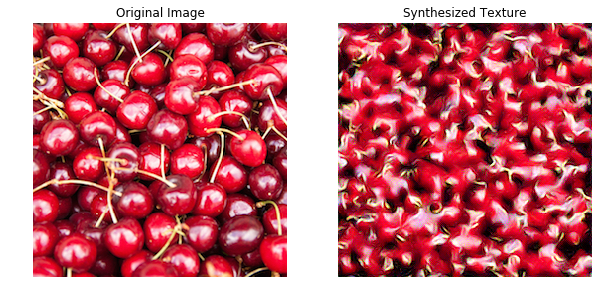

In [31]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1);
imshow(texture_img, title='Original Image')
plt.axis('off');

plt.subplot(1,2,2);
imshow(output_img, title='Synthesized Texture')
plt.axis('off');

plt.show()